In [1]:
import numpy as np
import pandas as pd
import mne
import os
import json
import os.path as op
from pathlib import Path

from sklearn.datasets import make_spd_matrix
from mne.io import RawArray
from mne import create_info
from mne_bids import BIDSPath

import statsmodels.tsa
import statsmodels as sm
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.statespace.varmax import VARMAX

import seaborn as sns
import matplotlib.pyplot as plt

from eztrack.io.base import _add_desc_to_bids_fname
from eztrack.io import read_derivative_npy
from eztrack.fragility import lds_raw_fragility, DiscreteLinearSystem
from eztrack.viz import _load_turbo, generate_heatmap
from eztrack.posthoc.hypo import compute_null

_load_turbo()

%matplotlib inline

In [2]:
def _simulate_eeg(n_chs, sfreq=1000):
    from mne.datasets import sample
    import mne
    
    # For this example, we will be using the information of the sample subject.
    # This will download the data if it not already on your machine. We also set
    # the subjects directory so we don't need to give it to functions.
    data_path = sample.data_path()
    subjects_dir = op.join(data_path, "subjects")
    subject = "sample"

    # To simulate sources, we also need a source space. It can be obtained from the
    # forward solution of the sample subject.
    fwd_fname = op.join(
        data_path, "MEG", subject, "sample_audvis-meg-eeg-oct-6-fwd.fif"
    )
    fwd = mne.read_forward_solution(fwd_fname)
    src = fwd["src"]

    # To select a region to activate, we use the caudal middle frontal to grow
    # a region of interest.
    selected_label = mne.read_labels_from_annot(
        subject, regexp="caudalmiddlefrontal-lh", subjects_dir=subjects_dir
    )[0]
    location = "center"  # Use the center of the region as a seed.
    extent = 10.0  # Extent in mm of the region.
    label = mne.label.select_sources(
        subject,
        selected_label,
        location=location,
        extent=extent,
        subjects_dir=subjects_dir,
    )

    # First, we get an info structure from the test subject.
    # evoked_fname = op.join(data_path, 'MEG', subject, 'sample_audvis-ave.fif')
    # info = mne.io.read_info(evoked_fname)
#     ch_names = [f"A{idx}" for idx in range(n_chs)]
#     info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types="eeg")
#     tstep = 1.0 / info["sfreq"]
    
    # First, we get an info structure from the test subject.
    evoked_fname = op.join(data_path, 'MEG', subject, 'sample_audvis-ave.fif')
    info = mne.io.read_info(evoked_fname)
    tstep = 1. / info['sfreq']

    # Define the time course of the activity for each source of the region to
    # activate. Here we use a sine wave at 18 Hz with a peak amplitude
    # of 10 nAm.
    source_time_series = np.sin(2.0 * np.pi * 18.0 * np.arange(100) * tstep) * 10e-9

    # Define when the activity occurs using events. The first column is the sample
    # of the event, the second is not used, and the third is the event id. Here the
    # events occur every 200 samples.
    n_events = 50
    events = np.zeros((n_events, 3))
    events[:, 0] = 100 + 200 * np.arange(n_events)  # Events sample.
    events[:, 2] = 1  # All events have the sample id.

    # Create simulated source activity. Here we use a SourceSimulator whose
    # add_data method is key. It specified where (label), what
    # (source_time_series), and when (events) an event type will occur.
    source_simulator = mne.simulation.SourceSimulator(src, tstep=tstep)
    source_simulator.add_data(label, source_time_series, events)

    # Project the source time series to sensor space and add some noise. The source
    # simulator can be given directly to the simulate_raw function.
    raw = mne.simulation.simulate_raw(info, stc=source_simulator, src=src)
    cov = mne.make_ad_hoc_cov(raw.info)
    mne.simulation.add_noise(raw, cov, iir_filter=[0.2, -0.2, 0.04])
    raw.plot()
    return raw

In [4]:
data = _simulate_eeg(n_chs=n_chs)

print(data.shape)

NameError: name 'n_chs' is not defined

In [5]:
def simulate_var(params, innovation='gaussian', nobs=None):
    p = len(params)
    k_endog = params[0].shape[0]

    if innovation in ['g', 'gaussian']:
        if nobs is None:
            raise ValueError('nobs needs to be an integer if innovation is not array')
        y = np.random.normal(size=(nobs + p, k_endog))
    else: 
        y = np.asarray(innovation).copy()
        if y.dtype != np.float:
            import warnings
            warnings.warn('dtype of innovation is not float')
    n, k = y.shape
    nobs = n - p
    
    for t in range(p, n):
        y[t] += sum(y[t - k].dot(A[k - 1]) for k in range(1, p+1))

    return y

In [6]:
# simulate Gaussian noise process
mean_vec = [0] * n_chs
mean = 0
variance = 1

# generate sub-gaussian matrix with independent entries
# cov = np.random.normal(loc=mean, scale=variance, size=(n_chs, n_chs))
# cov = (cov + cov.T) / 2.0
cov = make_spd_matrix(n_chs, random_state=random_state)

varmodel = VARMAX(data.T)
print(data.shape)
print(cov.shape)
y = varmodel.simulate(params=cov, nsimulations=10)

print(y.shape)

NameError: name 'n_chs' is not defined

(250,)


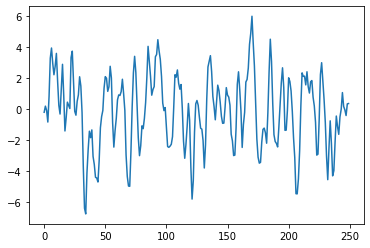

In [22]:
np.random.seed(12345)
arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
y = arma_generate_sample(ar, ma, 250)
# model = sm.tsa.ARMA(y, (2, 2)).fit(trend='nc', disp=0)
plt.plot(y)
print(y.shape)

# Generate Colored Noise

In [10]:
def almost_pink_noise(n_points, slope=1., plateau=0.05, random_state=None):
    """Generate some pink (1/f^slope) noise, with a plateau at low frequencies
    Parameters
    ----------
    n_points : integer
        Length of the noise signal
    slope : float
        The generated noise will have a (1/f^slope) energy
    plateau : float
        The frequencies will have the same energy between 0 and plateau
    """
    n_points = int(n_points)
    rng = check_random_state(random_state)
    uneven = n_points % 2
    x = (rng.randn(n_points // 2 + 1 + uneven) +
         rng.randn(n_points // 2 + 1 + uneven) * 1j)

    scaling = np.sqrt(np.arange(1, x.size + 1) ** slope)
    frequencies = np.linspace(0.0, 1.0, x.size)
    scaling[frequencies < plateau] = scaling[frequencies >= plateau][0]

    x /= scaling
    y = np.fft.irfft(x).real
    if uneven:
        y = y[:-1]
    return y / y.std()


def pink_noise(n_points, slope=1., random_state=None):
    """Generate some pink (1/f^slope) noise
    Parameters
    ----------
    n_points : integer
        Length of the noise signal
    slope : float
        The generated noise will have a (1/f^slope) energy
    """
    return almost_pink_noise(n_points=n_points, slope=slope, plateau=0.,
                             random_state=random_state)

def check_random_state(seed):
    """Turn seed into a np.random.RandomState instance
    If seed is None, return the RandomState singleton used by np.random.
    If seed is an int, return a new RandomState instance seeded with seed.
    If seed is already a RandomState instance, return it.
    Otherwise raise ValueError.
    """
    if seed is None or seed is np.random:
        return np.random.mtrand._rand
    if isinstance(seed, (numbers.Integral, np.integer)):
        return np.random.RandomState(seed)
    if isinstance(seed, np.random.RandomState):
        return seed
    raise ValueError('%r cannot be used to seed a numpy.random.RandomState'
                     ' instance' % seed)

In [68]:
n_chs = 50
n_samples = 5000

data = []
for idx in range(n_chs):
    ch_data = pink_noise(n_points=n_samples, slope=1.2)
    data.append(ch_data)
info = create_info(
    sfreq=1000, ch_names=[f"C{idx}" for idx in range(n_chs)], ch_types="seeg"
)
raw = RawArray(np.array(data) / 5e2, info=info)

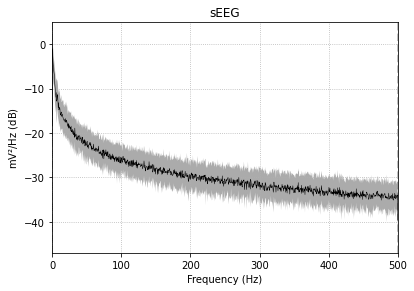

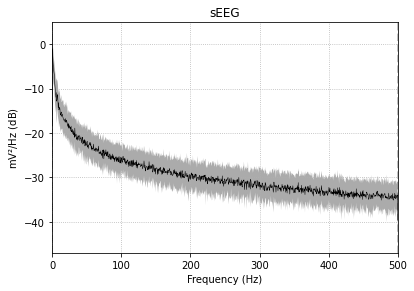

In [69]:
raw.plot_psd(average=True)

In [70]:
reference = 'monopolar'
pert_deriv, state_deriv, deltavecs_deriv = lds_raw_fragility(raw, reference=reference,
                                                             return_all=True)


  0%|          | 0/39 [00:00<?, ?it/s]

Using pinv least squares.


100%|██████████| 39/39 [00:06<00:00,  6.37it/s]
/Users/adam2392/Documents/interictal_study/.venv/lib/python3.8/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


(50, 50, 39)
<DiscreteLinearSystem | 50 x 50, Condition 90.496261950579>


<AxesSubplot:xlabel='Real part', ylabel='Imaginary part'>

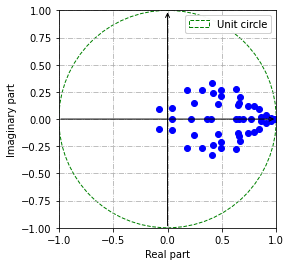

In [71]:
print(state_deriv[:, :, 0][0].shape)
A = state_deriv.get_data(start=3, stop=4).squeeze()

lds = DiscreteLinearSystem(A=A)

print(lds)
lds.plot_eigs()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


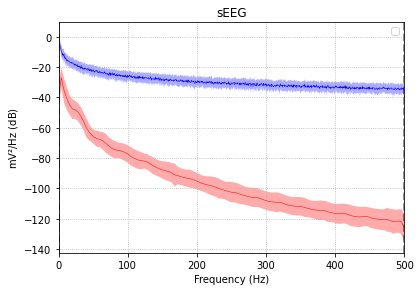

In [72]:
ax = lds.plot_psd(xtrue = raw.get_data(), winsize=250, info=raw.info)
ax.legend()

<AxesSubplot:>

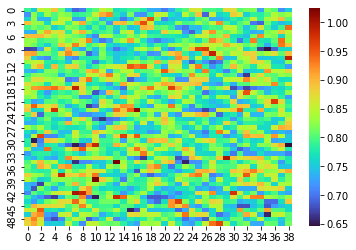

In [73]:
fig, ax = plt.subplots()
sns.heatmap(pert_deriv.get_data(), ax=ax, cmap='turbo')


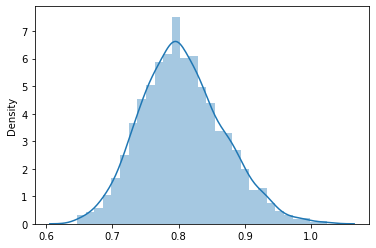

<AxesSubplot:ylabel='Density'>

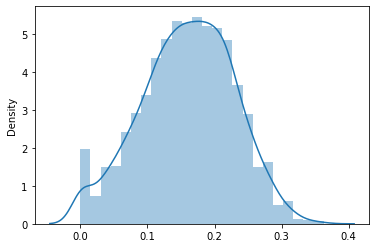

In [77]:
sns.distplot(pert_deriv.get_data())
plt.show(sns)

frag_mat = Normalize().compute_fragilitymetric(pert_deriv.get_data())
plt.figure()
sns.distplot(frag_mat)

# Demonstrate Gaussian Time Series Simulation and Null Distribution of Perturbation Norms

In [83]:
random_state = 123456
n_chs = 60
reference = 'average'

In [84]:
def generate_iid_ts(n_chs, mean=0, variance=1, n_samples=5000):
    data = []
    for idx in range(n_chs):
        data.append(np.random.normal(mean, variance, n_samples))
        
    return np.array(data)

(60, 5000)


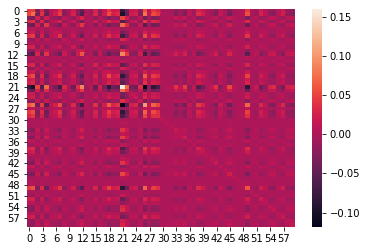

In [85]:
# simulate Gaussian noise process
mean_vec = [0] * n_chs
mean = 0
variance = 5

# generate sub-gaussian matrix with independent entries
# cov = np.random.normal(loc=mean, scale=variance, size=(n_chs, n_chs))
# cov = (cov + cov.T) / 2.0
cov = make_spd_matrix(n_chs, random_state=random_state)
cov = cov / np.linalg.norm(cov)
sns.heatmap(cov)

data = np.random.multivariate_normal(mean_vec, cov, 5000).T #5000 points
print(data.shape)

In [86]:
data = generate_iid_ts(n_chs, mean=mean, variance=variance)

data += np.random.multivariate_normal(mean_vec, cov, 5000).T #5000 points

Done


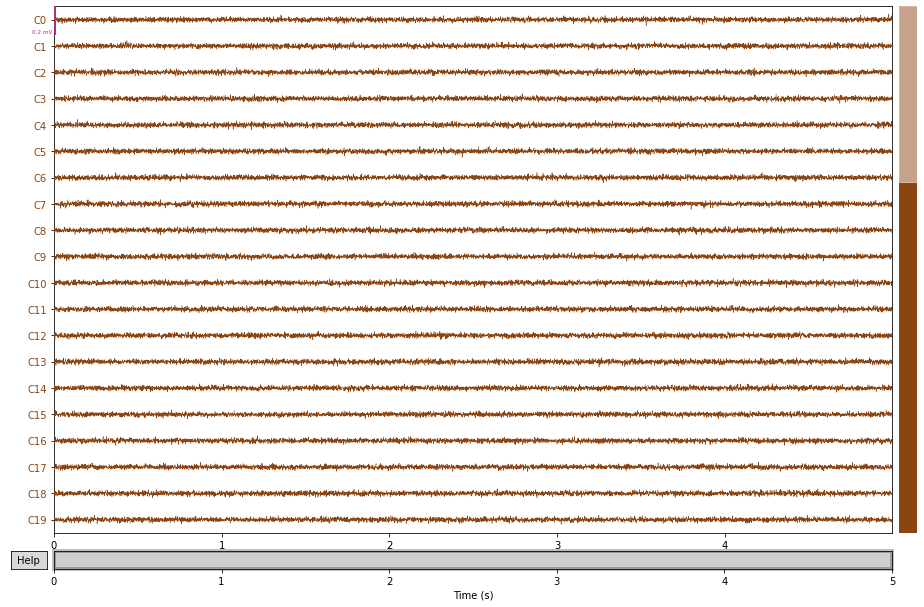

In [87]:
info = create_info(sfreq=1000, ch_names=[f'C{idx}' for idx in range(n_chs)], ch_types='seeg')
raw = RawArray(data / 5e5, info=info)

raw.plot()
print('Done')

In [88]:
pert_deriv, state_deriv, deltavecs_deriv = lds_raw_fragility(raw, reference=reference,
                                                             return_all=True)


 41%|████      | 16/39 [00:00<00:00, 116.65it/s]

Using pinv least squares.


100%|██████████| 39/39 [00:00<00:00, 156.54it/s]
/Users/adam2392/Documents/interictal_study/.venv/lib/python3.8/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


(60, 60, 39)
<DiscreteLinearSystem | 60 x 60, Condition 3.0605228012567364e+16>


<AxesSubplot:xlabel='Real part', ylabel='Imaginary part'>

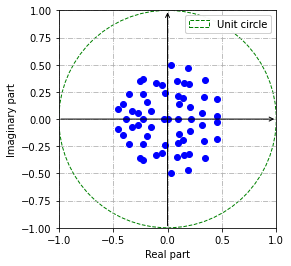

In [89]:
print(state_deriv[:, :, 0][0].shape)
A = state_deriv.get_data(start=3, stop=4).squeeze()

lds = DiscreteLinearSystem(A=A)

print(lds)
lds.plot_eigs()

No handles with labels found to put in legend.


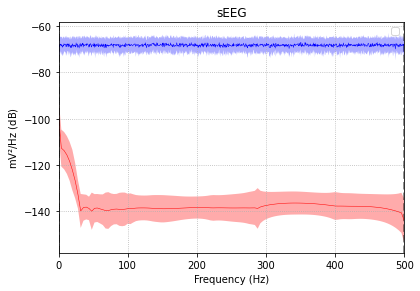

In [94]:
ax = lds.plot_psd(xtrue = raw.get_data(), winsize=250, info=raw.info)
ax.legend()

<AxesSubplot:>

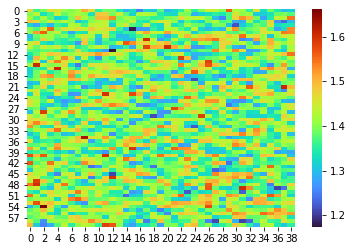

In [90]:
fig, ax = plt.subplots()
sns.heatmap(pert_deriv.get_data(), ax=ax, cmap='turbo')


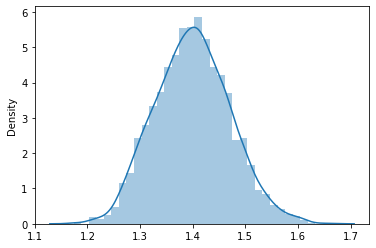

In [91]:
sns.distplot(pert_deriv.get_data())
plt.show(sns)

In [18]:
fragmat = pert_deriv.copy()
fragmat.normalize()
fig, ax = plt.subplots()
sns.heatmap(fragmat.get_data(), ax=ax, cmap='turbo')


<DerivativeArray | None, 10 x 39 (4.8 s), ~27 kB, data loaded>
['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
Got these picks:  [0 1 2 3 4 5 6 7 8 9]


<AxesSubplot:>

# Load Existing Dataset and Normalize wrt Null Distribution

In [3]:
from eztrack.utils import Normalize

In [4]:
# load in originally ran npy data
deriv_root = Path('/Users/adam2392/Dropbox/epilepsy_bids/derivatives/interictal/')
deriv_chain = Path('originalsampling') / 'fragility' / 'monopolar'

subject = 'pt1'
session = 'presurgery'
task = 'interictal'
acquisition = 'ecog'
datatype = 'ieeg'
desc = 'statematrix'
desc = 'perturbmatrix'
run = '01'

bids_path = BIDSPath(subject=subject, session=session, task=task,
                    acquisition=acquisition, datatype=datatype,
                    suffix=datatype, run=run)

deriv_basename = _add_desc_to_bids_fname(bids_path.copy().update(extension='.npy', check=False).basename, description=desc)
deriv_basename = Path(deriv_basename).with_suffix('.npy')
print(deriv_basename)

deriv_fpath = deriv_root / deriv_chain / f'sub-{subject}' / deriv_basename
# state_deriv = read_derivative_npy(deriv_fpath, verbose=False)
pert_deriv = read_derivative_npy(deriv_fpath, verbose=False)

sub-pt1_ses-presurgery_task-interictal_acq-ecog_run-01_desc-perturbmatrix_ieeg.npy
LOADING AN OLD DATASET...


In [5]:
ch_names = pert_deriv.ch_names
print(pert_deriv)

<DerivativeNumpy | sub-pt1_ses-presurgery_task-interictal_acq-ecog_run-01_desc-perturbmatrix_ieeg.npy, 84 x 3240 (404.9 s), ~168 kB, data not loaded>


In [6]:
# compute null distribution for this number of channels
n_chs = len(pert_deriv.ch_names)
method = 'powerlaw'
pert_deriv_null, _, _ = compute_null(n_chs=n_chs, method=method)

# compute mean and standard deviation
mean = pert_deriv_null.get_data().mean()
std = pert_deriv_null.get_data().std()

print(mean, std)

  0%|          | 0/39 [00:00<?, ?it/s]

Using pinv least squares.


100%|██████████| 39/39 [00:07<00:00,  5.35it/s]


0.8814800091145766 0.06673274064050237


/Users/adam2392/Documents/interictal_study/.venv/lib/python3.8/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


1.0456049946517185 0.005348291183342466
(84, 3240)


<AxesSubplot:>

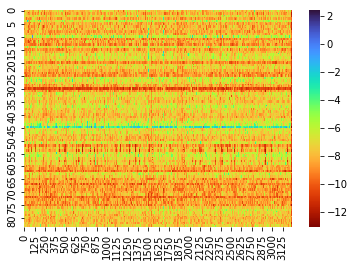

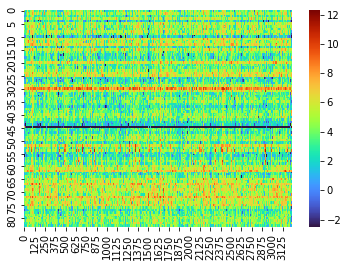

In [7]:
print(pert_deriv.get_data().max(), pert_deriv.get_data().min())
print(pert_deriv.get_data().shape)
pert_normalized = np.divide(pert_deriv.get_data() - mean, std)

frag_null = Normalize().compute_fragilitymetric(pert_deriv_null.get_data())
mean = frag_null.mean()
std = frag_null.std()

frag_mat = Normalize().compute_fragilitymetric(pert_deriv.get_data())
frag_normalized = np.divide(frag_mat - mean, std)


sns.heatmap(pert_normalized, cmap='turbo_r')

plt.figure()
sns.heatmap(frag_normalized, cmap='turbo')

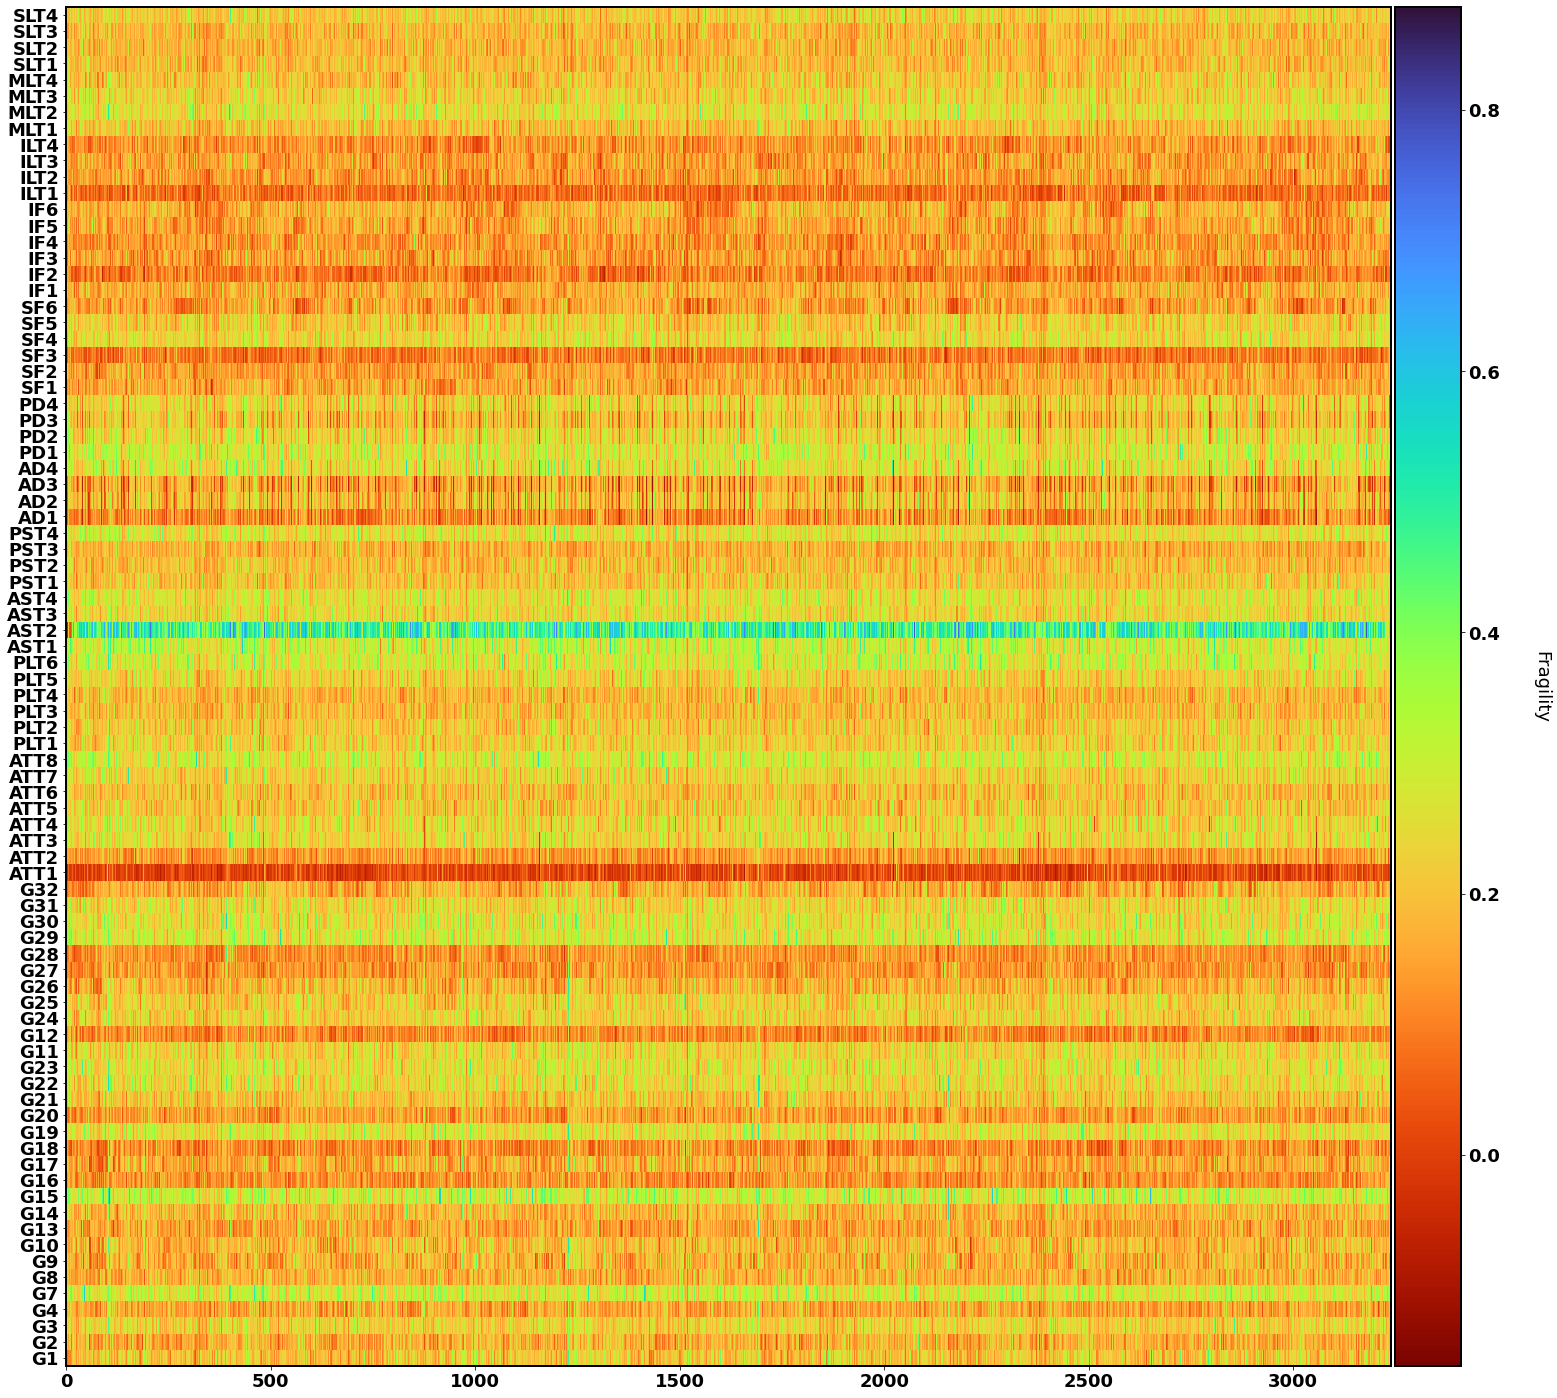

In [12]:
pert_normalized = pert_deriv.get_data() - mean
fig, ax = generate_heatmap(pert_normalized, ch_names=ch_names, cmap='turbo_r')
